In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import seaborn
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, OneSidedSelection, NeighbourhoodCleaningRule, RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from pickle import dump, load

pd.set_option('display.width', 1000)
pd.set_option('precision', 3)
seed = 4
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# Box plots
def my_boxplot(data, labels, xlabel, ylabel, title, loc):
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    pyplot.boxplot(data)
    ax.set_xticklabels(labels)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.title(title)
    pyplot.savefig(loc + '/' + xlabel + ".png")
    pyplot.show()


def visulize_boundary(model, X, Y, pos):
    model.fit(X[['age', 'avg_glucose_level']], Y)

    min1, max1 = X['age'].min() - 5, X['age'].max() + 5
    min2, max2 = X['avg_glucose_level'].min() - 5, X['avg_glucose_level'].max() + 5
    x1grid = np.arange(min1, max1, 1)
    y1grid = np.arange(min2, max2, 1)
    xx, yy = np.meshgrid(x1grid, y1grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1, r2))
    yhat = model.predict_proba(grid)
    yhat = yhat[:xx.shape[0]*xx.shape[1], 0]
    zz = yhat.reshape(xx.shape)
    cm = 'RdBu'
    pyplot.subplot(*pos)
    c = pyplot.contourf(xx, yy, zz, cmap=cm, alpha=0.2, levels=9)
    pyplot.colorbar(c)
    seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='true', s=20)

filename = "healthcare-dataset-stroke-data.csv"
data = pd.read_csv(filename, index_col="id")
features = ['age', 'avg_glucose_level', 'bmi', 'smoking_status', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']   #
target = 'stroke'

data = data[data['gender'] != "Other"]

# determine by percentage of unique values
categorical_ix = []
numerical_ix = []
n_uniques = data.nunique()
for col in features:
    percentage = n_uniques[col]/data.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)


outlier_strategy = 'Quantile_Range_Outlier_Detection'
q25, q75 = data['bmi'].quantile(0.25), data['bmi'].quantile(0.75)
iqr = q75 - q25
factor = 4
cut_off = iqr * factor
bmi_upper = q75 + cut_off
age_lower = 1
mask_outlier = (data["bmi"] > bmi_upper) | (data["age"] < age_lower)
mask_nonoutlier = mask_outlier == False

data = data[mask_nonoutlier].copy()

scoring = 'f1'
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=seed)


test_size = 0.33
X_train, X_test, Y_train, Y_test = train_test_split(data[features], data['stroke'], test_size=test_size, stratify=data['stroke'], random_state=seed)

CART training time: 1.4420456886291504s
CART predicting time: 0.09674215316772461s
[[1487  102]
 [  57   25]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1589
           1       0.20      0.30      0.24        82

    accuracy                           0.90      1671
   macro avg       0.58      0.62      0.59      1671
weighted avg       0.93      0.90      0.91      1671



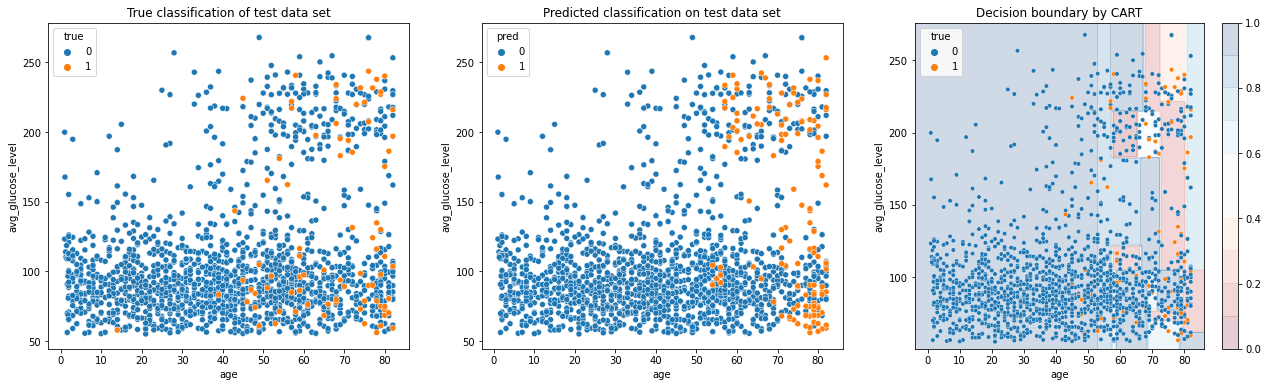

In [2]:

import time
start_train = time.time()

step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(sampling_strategy=0.3, random_state=seed))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11, ccp_alpha=0.001))

cart = Pipeline([step_trans,
                  step_smote,
                  step_cart])

# prepare the model
cart.fit(X_train, Y_train)
end_train = time.time()

# estimate on the test dataset
start_pred = time.time()
Y_pred = cart.predict(X_test)
end_pred = time.time()
print("CART training time: %ss" % (end_train - start_train))
print("CART predicting time: %ss" % (end_pred - start_pred))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

data_test = X_test.copy()
data_test['true'] = Y_test
data_test['pred'] = Y_pred
data_test.sort_values('true', inplace=True)

pyplot.figure(figsize=(22, 6))
pyplot.subplot(1, 3, 1)
seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of test data set')

data_test.sort_values('pred', inplace=True)
pyplot.subplot(1, 3, 2)
seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='pred')
pyplot.title('Predicted classification on test data set')


# visualize
model = Pipeline([step_smote,
                  step_cart])
visulize_boundary(model, X_train, Y_train, (1, 3, 3))

pyplot.title('Decision boundary by CART')
pyplot.savefig("./CART_figures/CART_final_prediction.png")
pyplot.show()

SVM: std = 0.033
CART: std = 0.045
ANN: std = 0.022


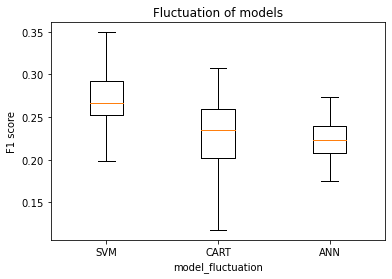

In [3]:
models = [('SVM', Pipeline([('Trans', ColumnTransformer([('StandardScaler', Pipeline([('Imputer', SimpleImputer()),
                                                                                      ('Scaler', StandardScaler())]),
                                                         numerical_ix),
                                                         ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                                        remainder='passthrough')),
                            ('SVC', SVC(C=0.5,gamma=0.125,class_weight={0:0.1,1:1}))
                           ])),
        ('CART', Pipeline([('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                                         ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                                        remainder='passthrough')),
                             ('SMOTEENN', SMOTEENN(sampling_strategy=0.3, random_state=seed)),
                              ('CART', DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11, ccp_alpha=0.001))
                            ])),
          ('ANN', Pipeline([('Trans', ColumnTransformer([('scale', Pipeline([('Imputer', SimpleImputer()),
                                                                                      ('Scaler', MinMaxScaler())]),
                                                          numerical_ix),
                                                        ('encode', OrdinalEncoder(), categorical_ix)],
                                                        remainder='passthrough')),
                           ('UnderSampling',RandomUnderSampler(random_state = 10)),
                           ('ANN', MLPClassifier(hidden_layer_sizes = 200, max_iter = 200))
                           ]))
          ]

names = []
results = []

for name, model in models:
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring, n_jobs = -1)
    names.append(name)
    results.append(cv_results)
    print("%s: std = %.3f" % (name, cv_results.std()))

my_boxplot(data=results, labels=names, xlabel='model_fluctuation', ylabel='F1 score', title='Fluctuation of models', loc="./")